In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import sys
from ultralytics import YOLO
import pickle
import matplotlib
# matplotlib.use('TkAgg')
# %matplotlib notebook
%matplotlib inline

In [2]:
#check if gpu is being used in m2
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print(x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [3]:
# !pip install 'git+https://github.com/facebookresearch/segment-anything.git'

  Cloning https://github.com/facebookresearch/segment-anything.git to /private/var/folders/16/jjjfbn9n5zs_w_zzkb1zjmzr0000gn/T/pip-req-build-vbn5nyog
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /private/var/folders/16/jjjfbn9n5zs_w_zzkb1zjmzr0000gn/T/pip-req-build-vbn5nyog
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36589 sha256=9fe0b37ed2e9505106470d25ddcebb0a5c139b7c55ddff9854c89f9874075373
  Stored in directory: /private/var/folders/16/jjjfbn9n5zs_w_zzkb1zjmzr0000gn/T/pip-ephem-wheel-cache-80_f1jw8/wheels/d5/11/03/7aca746a2c0e09f279b10436ced7175926bc38f650b736a648
Successfully built segment-anything


In [19]:
#mak sure you have the pth file in the same folder
# !wget -q 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth'

    To do:
        - Use open images to download and train data more animals

In [3]:
from segment_anything import sam_model_registry, SamPredictor

In [4]:
#https://github.com/facebookresearch/segment-anything/blob/main/notebooks/onnx_model_example.ipynb
def show_mask(mask, ax):
    color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))   

In [5]:
model = YOLO('yolov8n.pt')

In [6]:
!pwd

/Users/dipta/Documents/capstone/Model Training


In [6]:
image = cv2.imread('./raw-img/gatto/3.jpeg')

    {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}

In [54]:
def segment(image):
    
    objects = model(image, save = False, classes=[15, 16])
    
    if len(objects[0].boxes.cls) > 0 and int(objects[0].boxes.cls[0]) in (15, 16):
        sam_checkpoint = 'sam_vit_h_4b8939.pth'
        model_type = 'vit_h'
        device = 'mps'

        sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
        sam.to(device=device)

        predictor = SamPredictor(sam)
        predictor.set_image(image)
        input_box = np.array(objects[0].boxes.data[0][:4].tolist())

        masks, _, _ = predictor.predict(point_coords=None, point_labels=None,
                                   box = input_box[None,:],
                                   multimask_output = False,)

        plt.figure(figsize=(10,10))
        plt.imshow(image)
        show_mask(masks[0], plt.gca())
        # show_box(input_box, plt.gca())
        plt.show()
    
    else:
        print('There are no cats in your picture')

In [7]:
objects = model(image, save = False, classes=[15])


0: 448x640 1 cat, 44.6ms
Speed: 2.3ms preprocess, 44.6ms inference, 4.9ms postprocess per image at shape (1, 3, 448, 640)


In [8]:
objects[0].boxes.data[0][:4].tolist()

[11.798457145690918, 5.959310054779053, 264.642333984375, 178.7563934326172]

In [50]:
objects[0].boxes.cls

tensor([15.])

In [11]:
!ls

YOLOv8 and SAM.ipynb    opencv_starter.ipynb    yolov8n.pt
baseline_model_vgg16.h5 raw-img


In [11]:
sam_checkpoint = 'sam_vit_h_4b8939.pth'
model_type = 'vit_h'
device = 'mps'

In [12]:
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)

In [13]:
sam.to(device=device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [14]:
predictor = SamPredictor(sam)
predictor.set_image(image)
input_box = np.array(objects[0].boxes.data[0][:4].tolist())


In [15]:
masks, _, _ = predictor.predict(point_coords=None, point_labels=None,
                               box = input_box[None,:],
                               multimask_output = False,)

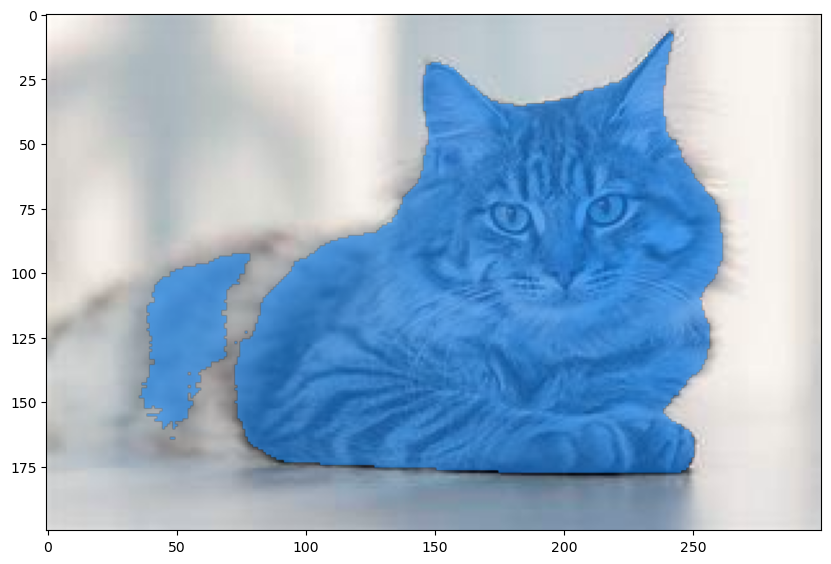

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
# show_box(input_box, plt.gca())
plt.show()


0: 640x576 1 cat, 80.1ms
Speed: 8.3ms preprocess, 80.1ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 576)


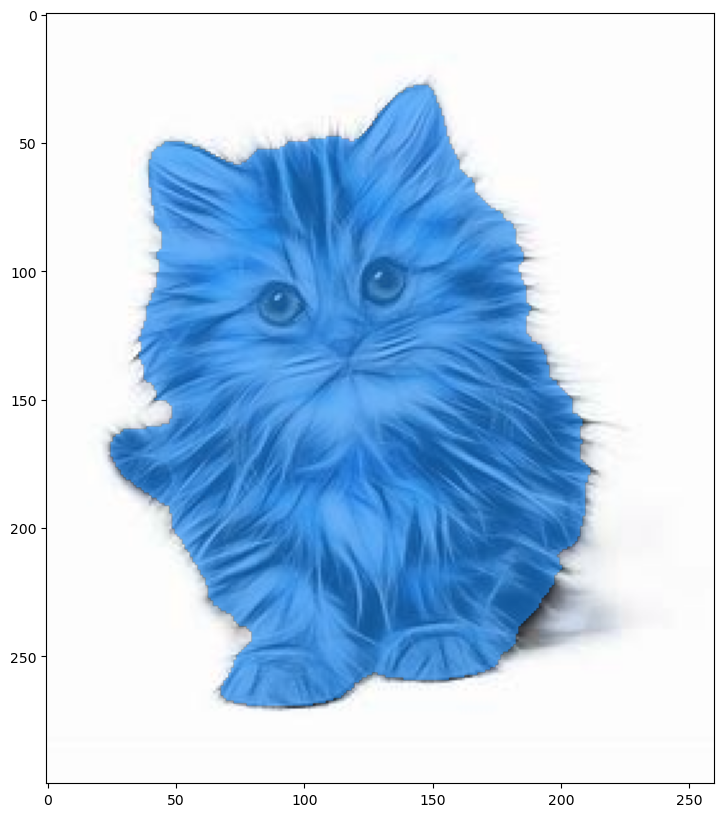

In [ ]:
image1 = cv2.imread('./raw-img/gatto/5.jpeg')
segment(image1)


0: 480x640 1 dog, 66.1ms
Speed: 4.3ms preprocess, 66.1ms inference, 6.1ms postprocess per image at shape (1, 3, 480, 640)


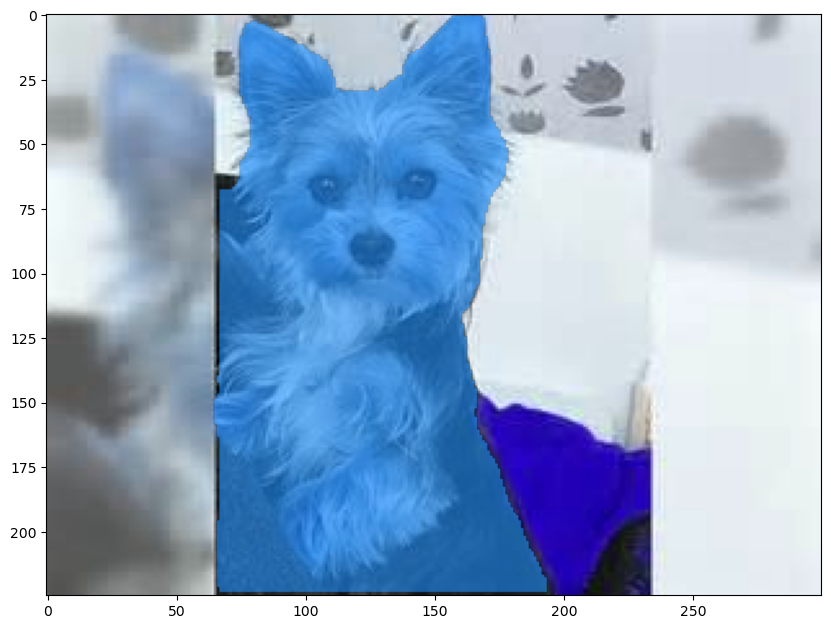

In [55]:
image2 = cv2.imread('./raw-img/cane/OIF-e2bexWrojgtQnAPPcUfOWQ.jpeg')
segment(image2)